# Моделирование времен прихода

## Реализация

In [ ]:
# Файл model_toa.py


import numpy as np
import matplotlib.pyplot as plt


class ModelTOA:
    def __init__(
        self,
        T: int,
        std_toa: float,
        time_start_jitter: float,
        signal_loss_rate: float,
        min_period: float,
        max_period: float,
        period_num: int,
        period_diff_threshold: float,
    ) -> None:
        """Класс моделирования времен прихода.

        Args:
            T (int): Длительность каждой пачки.
            std_toa (float): СКО времен прихода.
            time_start_jitter (float): Максимальный случайный сдвиг каждой пачки (равномерное распределение от 0 до этого значения).
            signal_loss_rate (float): Процент потерь сигналов.
            min_period (float): Минимальный период следования.
            max_period (float): Маскимальный период следования.
            period_num (int): Количество различных периодов следования (число источников).
            period_diff_threshold (int): Пороговое значение для разницы между периодами (разрешающая способность).
        """
        self.__T = T
        self.__std_toa = std_toa
        self.__time_start_jitter = time_start_jitter
        self.__signal_loss_rate = signal_loss_rate
        self.__period_diff_threshold = period_diff_threshold
        self.__period_array = self.__generate_unique_periods(
            min_period, max_period, period_num
        )

        self._toa_array = np.array([])
        self._labels = np.array([])
        self._sequence_lens = {}

    def __generate_unique_periods(
        self, min_period: float, max_period: float, period_num: int
    ) -> np.ndarray:
        periods = np.zeros(period_num)
        for i in range(period_num):
            while True:
                period = np.random.uniform(min_period, max_period)
                if all(abs(period - periods[:i]) > self.__period_diff_threshold):
                    periods[i] = period
                    break
        return np.sort(periods)

    def generate_toa(self) -> None:
        for i, period in enumerate(self.__period_array):
            time_arrival = np.arange(0, self.__T, period) + np.random.uniform(
                0, self.__time_start_jitter, 1
            )
            time_arrival += np.random.normal(0, self.__std_toa, len(time_arrival))

            mask = np.random.uniform(size=len(time_arrival)) >= self.__signal_loss_rate

            time_arrival = time_arrival[mask]
            label = np.ones(len(time_arrival)) * i
            self._labels = np.concatenate([self._labels, label])

            self._sequence_lens[i] = len(time_arrival)
            self._toa_array = np.concatenate([self._toa_array, time_arrival])

        self._labels = self._labels[np.argsort(self._toa_array)]
        self._toa_array = np.sort(self._toa_array)
        self._toa_array -= min(self._toa_array)

    def get_labels(self) -> np.ndarray:
        return self._labels

    def get_toa_array(self) -> np.ndarray:
        return self._toa_array

    def get_period_array(self) -> np.ndarray:
        return self.__period_array

    def get_std_toa(self) -> float:
        return self.__std_toa

    def get_T(self) -> int:
        return self.__T

    def get_signal_loss_rate(self) -> float:
        return self.__signal_loss_rate

    def draw_scatter_plot(self, start: int, end: int) -> None:
        plt.title("Диаграмма рассеяния времен прихода")
        plt.ylabel("Время прихода, с")
        plt.xlabel("Число отсчетов")

        unique_labels = np.unique(self._labels[start:end])
        colors = plt.get_cmap("viridis", len(unique_labels))(
            np.arange(len(unique_labels))
        )

        scatter = plt.scatter(
            x=np.arange(len(self._toa_array))[start:end],
            y=self._toa_array[start:end],
            c=self._labels[start:end],
            cmap="viridis",
        )

        legend_elements = [
            plt.Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                markerfacecolor=colors[i],
                markersize=10,
                label=f"Период {int(label)}",
            )
            for i, label in enumerate(unique_labels)
        ]
        plt.legend(handles=legend_elements, title="Периоды")

        plt.grid()
        plt.show()

## Использование

In [ ]:
model_toa = ModelTOA(T=4,
                     std_toa=1e-6,
                     time_start_jitter=1e-2,
                     signal_loss_rate=0.3,
                     min_period=1e-3,
                     max_period=10e-3,
                     period_num=5,
                     period_diff_threshold=5e-5)
model_toa.generate_toa()

# Обзор алгоритмов оценки количества источников по временам прихода

## Получение данных от модели

In [ ]:
toa_array = model_toa.get_toa_array()
period_array = model_toa.get_period_array()
T = model_toa.get_T()
signal_loss_rate = model_toa.get_signal_loss_rate()
std_toa = model_toa.get_std_toa()

## Расчет матрицы разностей

In [ ]:
# пороги по возможным периодам
min_period_threshold = 0.05e-3
max_period_threshold = 20e-3

In [ ]:
diff_matrix = (toa_array - toa_array.reshape(-1,1))

diff_matrix[diff_matrix <= min_period_threshold] = -100
diff_matrix[diff_matrix >= max_period_threshold] = -100

phase_matrix = np.exp(1j * 2 * np.pi * (toa_array % diff_matrix) / diff_matrix)

diff = diff_matrix.flatten()
phase = phase_matrix.flatten()

diff_index = np.argwhere(diff > 0)
phase = phase[diff>0]
diff = diff[diff>0]
diff.shape

(49158,)

## Функция порогов PRI для гистограмм

In [ ]:
def get_thresholds(periods: np.ndarray, T: int, hist_n: np.ndarray, signal_loss_rate: float, x: float, g: float):
    N = T * np.sum(1 / periods)
    B = len(hist_n)
    d = np.max(hist_n) - np.mean(hist_n)
    x *= signal_loss_rate
    thresholds = [x * (N - d) * np.exp(-period / g * B) for period in periods]
    return np.array(thresholds)

## Delta-T гистограмма

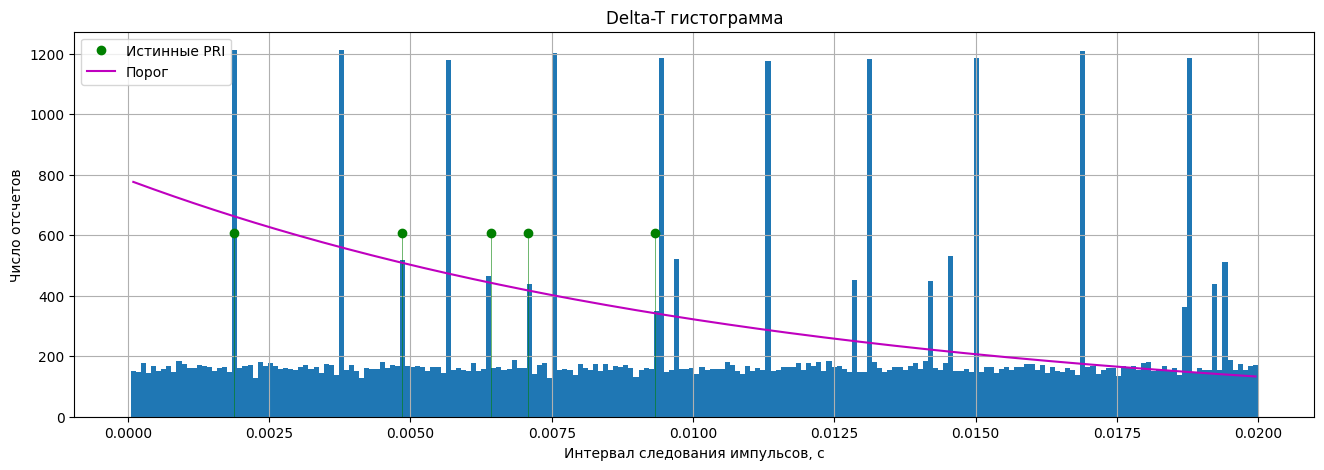

In [ ]:
plt.figure(figsize=(16,5))
hist_res = plt.hist(diff, bins = 'sqrt')

edges = hist_res[1]
mid_bins = (edges[1:] + edges[:-1]) / 2

thresholds = get_thresholds(periods=mid_bins,
                            T=T,
                            hist_n=hist_res[0],
                            signal_loss_rate=signal_loss_rate,
                            x=1e-2,
                            g=2.5)

plt.plot(period_array, [max(hist_res[0])*0.5] * len(period_array), 'go', label="Истинные PRI")
plt.vlines(period_array, 0, max(hist_res[0])*0.5, 'g', linewidth=0.4)
plt.plot(mid_bins, thresholds, color='m', label='Порог')

plt.title('Delta-T гистограмма')
plt.xlabel('Интервал следования импульсов, с')
plt.ylabel('Число отсчетов')
plt.grid()
plt.legend()
plt.show()

## Комплексная Delta-T гистограмма

In [ ]:
bin_edges = hist_res[1]
mid_bins = (bin_edges[:-1] + bin_edges[1:]) / 2
count = np.zeros(len(bin_edges), dtype = 'complex')
for ph, val in zip(phase, diff):
    ind = np.searchsorted(bin_edges, val, side='right') - 1
    count[ind] += ph
complex_amplitude = abs(count)

In [ ]:
thresholds = get_thresholds(periods=mid_bins,
                            T=T,
                            hist_n=hist_res[0],
                            signal_loss_rate=signal_loss_rate,
                            x=1e-3,
                            g=15)

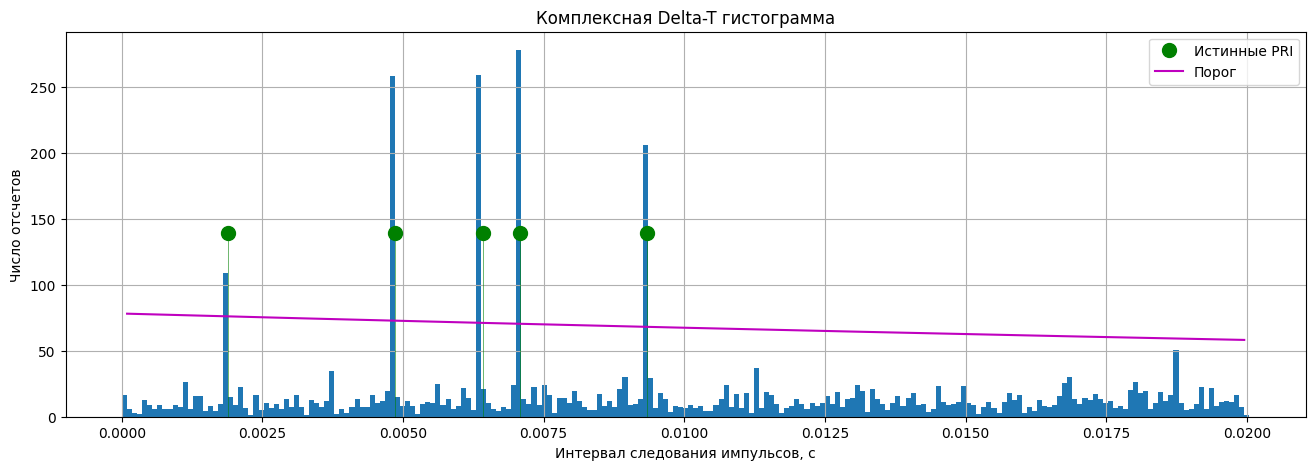

In [ ]:
plt.figure(figsize=(16,5))

plt.bar(bin_edges, complex_amplitude, width=bin_edges[1]-bin_edges[0])
plt.plot(period_array, [max(complex_amplitude)*0.5] * len(period_array), 'go', markersize=10, label="Истинные PRI")
plt.vlines(period_array, 0, max(complex_amplitude)*0.5, 'g', linewidth=0.4)
plt.plot(mid_bins, thresholds, color='m', label='Порог')

plt.title('Комплексная Delta-T гистограмма')
plt.xlabel('Интервал следования импульсов, с')
plt.ylabel('Число отсчетов')
plt.grid()
plt.legend()
plt.show()

## Быстрое преобразованием Фурье с временным кодированием

In [ ]:
from tqdm import tqdm

delta_t = 1e-6 # разрешение по времени

signal = np.zeros(int(max(toa_array) / delta_t)+2)
time_array = np.arange(0, max(toa_array)+delta_t, delta_t)

for toa in tqdm(toa_array):
    signal[np.searchsorted(time_array, toa, side='right')] = 1

print(f'\ntoa len: {len(toa_array)}')
print(f'time coding signal len: {len(signal)}')

100%|██████████| 3175/3175 [00:00<00:00, 171179.58it/s]


toa len: 3175
time coding signal len: 4004493


In [ ]:
fft_result = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), delta_t)
amplitude = np.abs(fft_result)
frequencies = frequencies[:len(frequencies)//2]
amplitude = amplitude[:len(amplitude)//2]
fs = 1 / delta_t
N = int((2 * len(amplitude)) / (fs * min_period_threshold) / 16)

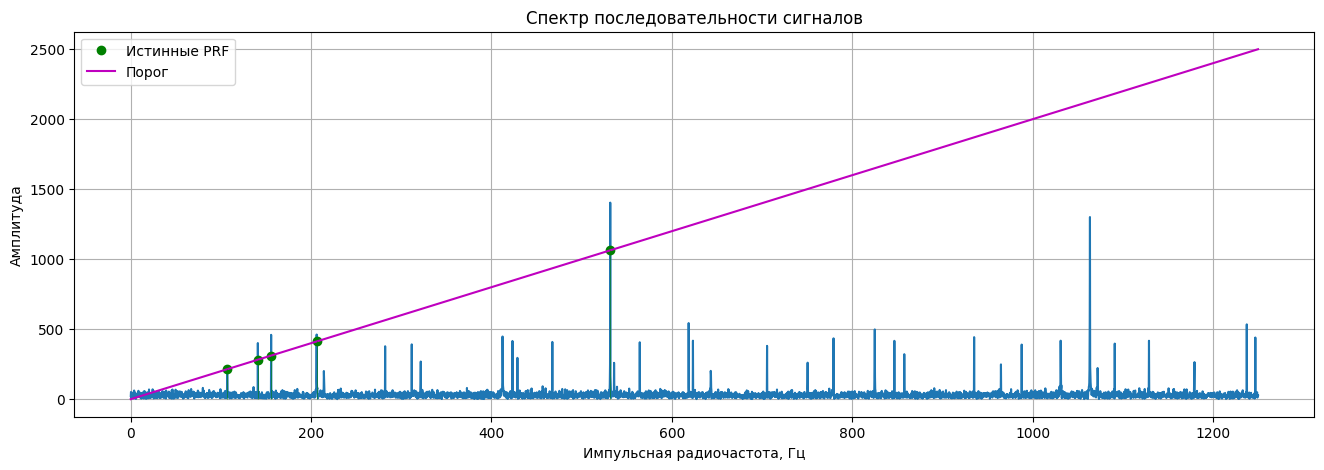

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(frequencies[1:N], amplitude[1:N])
plt.plot(1 / period_array, (T / period_array)*0.5, 'go', label="Истинные PRF")
plt.plot(frequencies[1:N], (T * frequencies[1:N])*0.5, 'm', label="Порог")
plt.vlines(1 / period_array, 0, (T / period_array)*0.5, 'g', linewidth=0.4)

plt.title('Спектр последовательности сигналов')
plt.xlabel('Импульсная радиочастота, Гц')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()
plt.show()

## Прямое быстрое преобразование Фурье

In [ ]:
signal_1 = np.sin(2 * np.pi * (toa_array) / (max(toa_array)))

n_fft = 2 ** int(np.ceil(np.log2(len(toa_array))))

fft_result = np.fft.fft(signal_1, n_fft)
frequencies = np.fft.fftfreq(n_fft, (max(toa_array)/(len(toa_array))))
amplitude = np.abs(fft_result)
frequencies = frequencies[:len(frequencies)//2]
amplitude = amplitude[:len(amplitude)//2]

Nmin = int(n_fft*0.02)
Nmax = -1

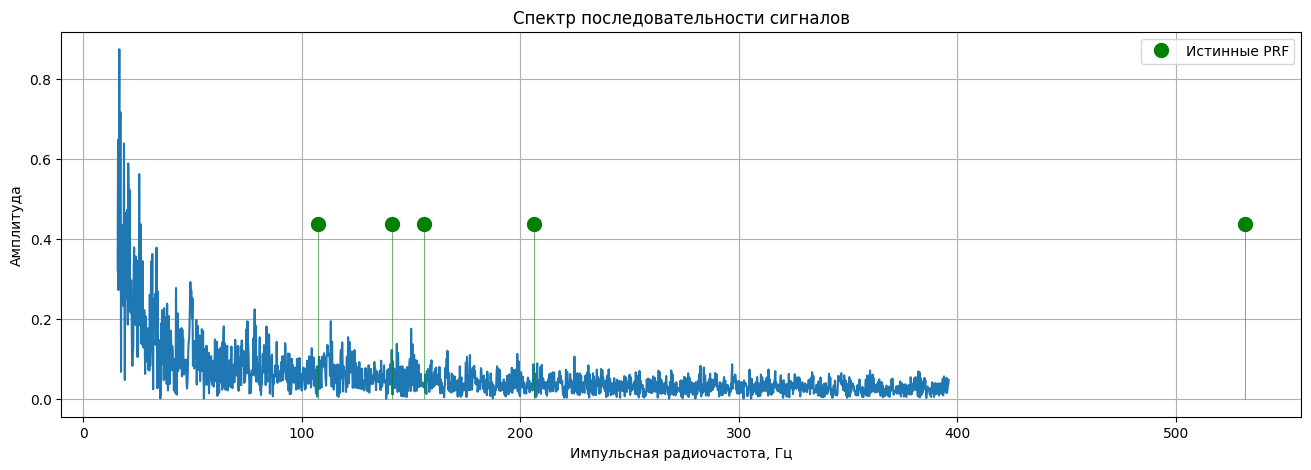

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(frequencies[Nmin:Nmax], amplitude[Nmin:Nmax])

plt.plot(1 / period_array, [max(amplitude[Nmin:Nmax])*0.5] * len(period_array), 'go', markersize=10, label="Истинные PRF")
plt.vlines(1 / period_array, 0, max(amplitude[Nmin:Nmax])*0.5, 'g', linewidth=0.4)
plt.title('Спектр последовательности сигналов')
plt.xlabel('Импульсная радиочастота, Гц')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()
plt.show()

## Дельта-функция с прямым преобразованием Фурье

In [ ]:
min_freq = 50
max_freq = 1000
frequencies = np.log(np.linspace(np.exp(min_freq/max_freq), np.exp(1), num = 8000)) * max_freq

amplitude = np.exp(-1j * 2 * np.pi * frequencies * toa_array.reshape(-1,1))
amplitude = np.abs(np.sum(amplitude, axis=0))

alpha = 0.5

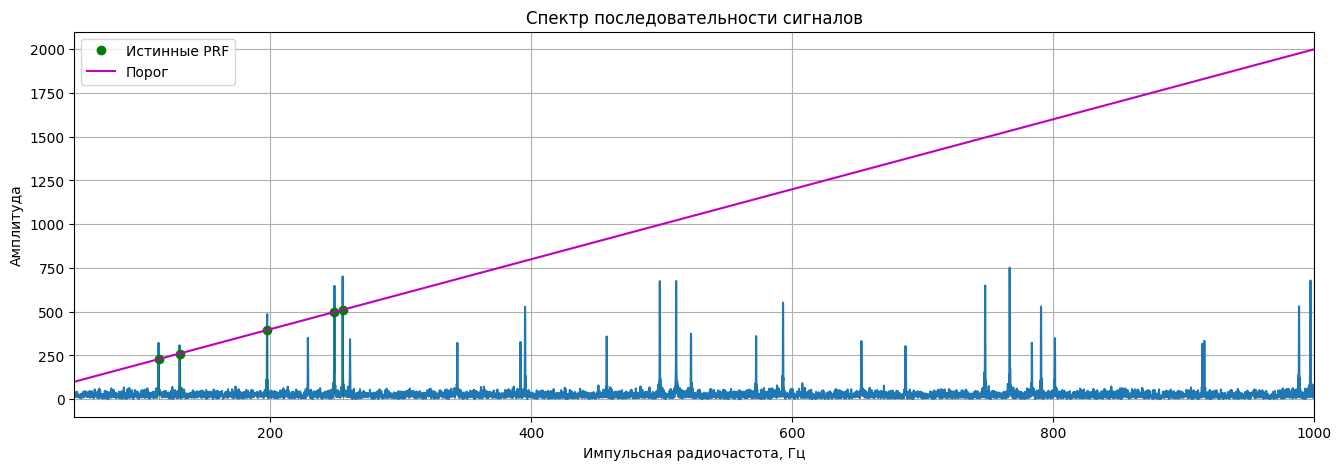

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(frequencies, amplitude)
plt.plot(1 / period_array, (T / period_array)*alpha, 'go', label="Истинные PRF")
plt.plot(frequencies, (T * frequencies)*alpha, 'm', label="Порог")
plt.vlines(1 / period_array, 0, (T / period_array)*0.5, 'g', linewidth=0.4)

plt.xlim(min_freq, max_freq)
plt.title('Спектр последовательности сигналов')
plt.xlabel('Импульсная радиочастота, Гц')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()
plt.show()

In [ ]:
PRF = frequencies[amplitude > (T * frequencies)*alpha]
amp = amplitude[amplitude > (T * frequencies)*alpha]
est_PRF = np.sort(PRF[np.argsort(amp)])
est_PRF

array([114.48364311, 130.52401961, 197.54657789, 197.71760784,
       249.21243091, 255.52729119])